In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from matplotlib import pyplot as plt
%matplotlib inline
from cycler import cycler
import jax.numpy as jnp
import jax.scipy.stats.norm as jnorm
from jax import grad

try:
    import seaborn as sns
except ModuleNotFoundError:
    %pip install seaborn
    import seaborn as sns

try:
    import probml_utils as pml
    from probml_utils import latexify, savefig
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
    from probml_utils import latexify, savefig
try:
    from statsmodels.discrete.discrete_model import Probit
except ModuleNotFoundError:
    %pip install -qq statsmodels
    from statsmodels.discrete.discrete_model import Probit

In [ ]:
latexify(width_scale_factor = 2, fig_height = 1.5)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 272 kB 7.7 MB/s 
     |████████████████████████████████| 88 kB 7.5 MB/s 
     |████████████████████████████████| 125 kB 59.5 MB/s 
     |████████████████████████████████| 72 kB 539 kB/s 
     |████████████████████████████████| 1.1 MB 60.3 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


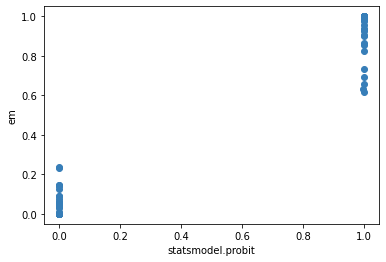

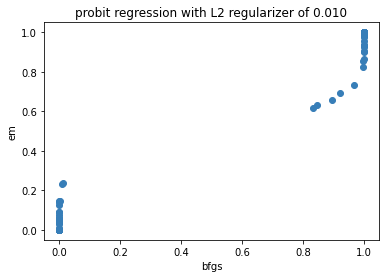

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


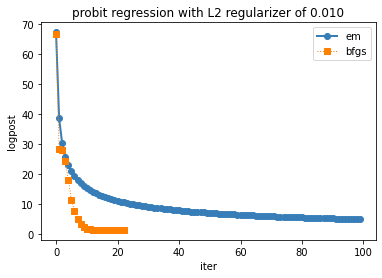

In [1]:




cb_color = ['#377eb8', '#ff7f00']

cb_cycler = (cycler(linestyle=['-', '--', '-.']) * cycler(color=cb_color))
plt.rc('axes', prop_cycle=cb_cycler)

np.random.seed(0)


class ProbitReg:

    def __init__(self):
        self.loglikehist = []
        self.max_iter = 100
        self.tolerance = 1e-4
        self.w = []

    # Probit-loss = (1-y)*log(1-gauss.cdf(X.w)) - (1-y)*log(gauss.cdf(-(X.w))
    def probitloss(self, X, y, w):  # NLL
        return -jnp.sum(y * jnorm.logcdf(jnp.dot(X, w))) - \
               jnp.sum((1 - y) * jnorm.logcdf(-jnp.dot(X, w)))

    def objfn(self, X, y, w, lam):  # penalized likelihood.
        return jnp.sum(lam * jnp.square(w[1:])) - self.probitloss(X, y, w)

    def probreg_fit_em(self, X, y, lam):

        self.w = np.linalg.lstsq(
            X + np.random.rand(X.shape[0], X.shape[1]), y, rcond=None)[0].reshape(-1, 1)

        def estep(w):
            u = X @ w
            z = u + norm.pdf(u) / ((y == 1) - norm.cdf(-u))
            loglik = self.objfn(X, y, w, lam)
            return z, loglik

        # M step function is the ridge regression
        def mstep(X, y, lam):
            return ridge_reg(X, y, lam)

        i = 1
        stop = False
        while not stop:
            z, loglike = estep(self.w)
            self.loglikehist.append(loglike)
            self.w = mstep(X, z, lam)
            if i >= self.max_iter:
                stop = True
            elif i > 1:
                # if slope becomes less than tolerance.
                stop = np.abs((self.loglikehist[i - 1] - self.loglikehist[i - 2]) / (
                        self.loglikehist[i - 1] + self.loglikehist[i - 2])) <= self.tolerance / 2

            i += 1

        self.loglikehist = self.loglikehist[0:i - 1]

        return self.w, np.array(self.loglikehist)

    def probit_reg_fit_gradient(self, X, y, lam):
        winit = jnp.linalg.lstsq(
            X + np.random.rand(X.shape[0], X.shape[1]), y, rcond=None)[0].reshape(-1, 1)

        self.loglikehist = []

        self.loglikehist.append((-self.objfn(X, y, winit, lam)))

        def obj(w):
            w = w.reshape(-1, 1)
            # PNLL
            return self.probitloss(X, y, w) + jnp.sum(lam * jnp.square(w[1:]))

        def grad_obj(w):
            return grad(obj)(w)

        def callback(w):
            loglik = obj(w)  # LL

            self.loglikehist.append(loglik)

        res = minimize(
            obj,
            x0=winit,
            jac=grad_obj,
            callback=callback,
            method='BFGS')
        return res['x'], np.array(self.loglikehist[0:-1])

    def predict(self, X, w):
        p = jnorm.cdf(jnp.dot(X, w))
        y = np.array((p > 0.5), dtype='int32')
        return y, p


# using matrix inversion for ridge regression
def ridge_reg(X, y, lambd):  # returns weight vectors.
    D = X.shape[1]
    w = np.linalg.inv(X.T @ X + lambd * np.eye(D, D)) @ X.T @ y

    return w


def flip_bits(y, p):
    x = np.random.rand(y.shape[0], 1) < p
    y[x < p] = 1 - y[x < p]
    return y


n, d = 100, 2
data_x = np.random.randn(n, d)
w = np.random.randn(d, 1)
data_y = flip_bits((data_x @ w > 0), 0)

lam = 1e-2

# statsmodel.Probit
sm_probit_reg = Probit(exog=data_x, endog=data_y).fit(disp=0, method='bfgs')
sm_probit_prob = sm_probit_reg.predict(exog=data_x)

# Our Implementation:
probit_reg = ProbitReg()

# EM:
em_w, obj_trace_em = probit_reg.probreg_fit_em(data_x, data_y, lam)
em_ypred, em_prob = probit_reg.predict(data_x, em_w)

# gradient:
gradient_w, obj_trace_gradient = probit_reg.probit_reg_fit_gradient(
    data_x, data_y, lam)
gradient_ypred, gradient_prob = probit_reg.predict(data_x, gradient_w)

plt.figure()
plt.plot(sm_probit_prob, em_prob, 'o')
plt.xlabel('statsmodel.probit')
plt.ylabel('em')

plt.figure()
plt.plot(gradient_prob, em_prob, 'o')
plt.xlabel('bfgs')
plt.ylabel('em')
plt.title('probit regression with L2 regularizer of {0:.3f}'.format(lam))
plt.show()

plt.figure()
plt.plot(-obj_trace_em.flatten(), '-o', linewidth=2)
plt.plot(obj_trace_gradient.flatten(), ':s', linewidth=1)
plt.legend(['em', 'bfgs'],frameon = False)
plt.title('probit regression with L2 regularizer of {0:.3f}'.format(lam))
plt.ylabel('logpost')
plt.xlabel('iter')
sns.despine()
pml.savefig('probitRegDemoNLL.pdf')
plt.show()
